### RFC

### import modules and configure notebook

In [165]:
import pandas as pd
import numpy as np
import swifter
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

pd.set_option('max.rows', None)
pd.set_option('max.columns', None)

from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

%matplotlib inline

### Load variables stored by data_preproccessing notebook

In [169]:
%store -r train_data_formodel
%store -r test_data
%store -r my_data
%store -r uniques
%store -r best_feats
%store -r X_test_labeled_df
%store -r site_frequencies_df



### configurations
* save_plots -> True|False
* random_seed_state -> number, sets random state for model and for stratified splits 
* classify_bedrock_only -> True|False
* pickle_model -> True|False, wether model should be serialised and saved
* pickle_model_name -> string, name of serialised model
* grid_search -> True|False, if set to true then grid search is performed to identify optimum hyperparamaters for model 
* scale -> True|False if set to True then features scaled to all have mean value 0 and standard deviation 1
* pickle_file_path -> string,  filepath for serialised model to be saved to
* modelName -> string, type of model to use 'rfc'|'gbm'|'svm'|'knn'
* trainTestSplitTotalIters -> total number of iterations of train test split for cross validation

In [3]:
save_plots = False
random_seed_state = 42
classify_bedrock_only = False
grid_search = False
scale = True
save_predictions = False
modelName = 'svm'
trainTestSplitTotalIters = 10

### if only bedrock sites are classified then classes are label encoded, if bedrock sites alone are not being classified then the class sites would have already been label encoded in the 1 data_preproccessing notebook 

if classify_bedrock_only:
    train_data_formodel['class'], uniques = pd.factorize(train_data_formodel['class'])
    train_data_formodel = train_data_formodel[train_data_formodel['Geology']=='Bedrock']

### counts of instances in all classes before oversampling

In [4]:
train_data_formodel['class'].value_counts()

4     105
17    100
18     61
0      53
10     47
13     45
15     36
16     36
2      36
12     30
11     30
8      30
7      30
5      30
6      27
9      27
1      24
14     21
3      18
Name: class, dtype: int64

### The class column is stored as the variable y 

In [5]:
y = np.array(train_data_formodel['class'])

### The variables identified as best by the 2 feature_selection notebook are used as features

In [6]:
train_data_feats = train_data_formodel[best_feats]

### address class imbalance using synthetic minority oversampling technique (SMOTE) algorithm

In [7]:
if scale:
    my_scaler = StandardScaler()
    X = np.array(my_scaler.fit_transform(np.array(train_data_feats)))
else:
    X = np.array(np.array(train_data_feats))

### the dimensions of the class and features are checked

In [8]:
print(X.shape)
print(y.shape)

(786, 30)
(786,)


### Carry out 10-f0ld stratified cross validation, class f1 scores and macro f1 scores are calculated

In [9]:
if modelName == 'rfc':
    skf = StratifiedKFold(n_splits=10, random_state=random_seed_state)
    skf.get_n_splits(X, y)
    class_f1_scores = []
    macro_f1_scores = []
    accuracy_scores = []
    feat_imp =[]
    f1_dict = {}
    feat_imp_dict = {}
    count = 0

    #for train_index, test_index in skf.split(X, y):
    for i in range(0, trainTestSplitTotalIters):
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify = y, random_state=42)
        count = count + 1
        print('making model:')
        key = 'round' + str(count)
        print(count)


        X_post_smote, y_post_smote = SMOTE(random_state=42).fit_sample(X_train, y_train)


        ###this section optimises model paramaters by gridsearch 

        esti = RandomForestClassifier(n_estimators=100, max_features = 'auto')


        max_depth = [80, 100, 120]
        min_samples_split = [2, 3, 4]
        min_samples_leaf = [1, 2, 3]

        param_grid = {
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                      }

        clf = GridSearchCV(estimator = esti, param_grid= param_grid,
                                  n_jobs=-1, scoring='f1_macro', cv = 5, verbose=3)
        print('running grid serach on this training data fold')
        clf.fit(X_post_smote, y_post_smote)
        optimumEstimator = clf.best_estimator_
        optimumEstimator.fit(X_post_smote, y_post_smote)
        print('gridsearch identified optimum paramaters for the current training data fold, now model with optimumn paramaters predicting using test_data for evaluation')

        y_pred = optimumEstimator.predict(X_test)
        class_f1_scores = f1_score(y_test, y_pred, average = None)
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append(accuracy)
        macro_f1_scores.append(f1_score(y_test, y_pred, average = 'macro'))
        f1_dict[key] = class_f1_scores 
        feat_imp_dict[key] = optimumEstimator.feature_importances_
        
 

In [10]:
if modelName == 'gbm':
    skf = StratifiedKFold(n_splits=10, random_state=random_seed_state)
    skf.get_n_splits(X, y)
    class_f1_scores = []
    macro_f1_scores = []
    accuracy_scores = []
    feat_imp =[]
    f1_dict = {}
    feat_imp_dict = {}
    count = 0


    for i in range(0, trainTestSplitTotalIters):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify = y, random_state=42)
        count = count + 1
        print('making model:')
        key = 'round' + str(count)
        print(count)


        X_post_smote, y_post_smote = SMOTE(random_state=42).fit_sample(X_train, y_train)


        ###this section optimises model paramaters by gridsearch 

        esti = xgb.XGBClassifier(n_estimators=5)


        max_depth = [80, 100, 120]
        min_child_weight = [0,1,3]
        gamma = [0,3,5,7,9]



        param_grid = {
                   'max_depth': max_depth,
                       'min_child_weight':min_child_weight,
                       'gamma':gamma
                      }

        clf = GridSearchCV(estimator = esti, param_grid= param_grid,
                                  n_jobs=-1, scoring='f1_macro', cv = 5, verbose=3)
        print('running grid serach on this training data fold')
        clf.fit(X_post_smote, y_post_smote)
        optimumEstimator = clf.best_estimator_
        optimumEstimator.fit(X_post_smote, y_post_smote)
        print('gridsearch identified optimum paramaters for the current training data fold, now model with optimumn paramaters predicting using test_data for evaluation')

        y_pred = optimumEstimator.predict(X_test)
        class_f1_scores = f1_score(y_test, y_pred, average = None)
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append(accuracy)
        macro_f1_scores.append(f1_score(y_test, y_pred, average = 'macro'))
        f1_dict[key] = class_f1_scores 
        feat_imp_dict[key] = optimumEstimator.feature_importances_

In [11]:
if modelName == 'svm':
    skf = StratifiedKFold(n_splits=10, random_state=random_seed_state)
    skf.get_n_splits(X, y)
    class_f1_scores = []
    macro_f1_scores = []
    accuracy_scores = []
    feat_imp =[]
    f1_dict = {}
    feat_imp_dict = {}
    count = 0

  
    for i in range(0, trainTestSplitTotalIters):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify = y, random_state=42)
        count = count + 1
        print('making model:')
        key = 'round' + str(count)
        print(count)


        X_post_smote, y_post_smote = SMOTE(random_state=42).fit_sample(X_train, y_train)


        ###this section optimises model paramaters by gridsearch 

        esti = SVC()


        param_grid = {
            'C': [0.01, 0.1, 10, 100], 
            #'C': [0.01, 0.1, 1, 10, 100, 1000, 10000], 
            'class_weight':['balanced', None], 
            #'gamma':[0.001, 0.01, 0.1, 1, 10]
            'gamma':[0.01, 0.1, 10, 100]
                }

        clf = GridSearchCV(estimator = esti, param_grid= param_grid,
                                  n_jobs=-1, scoring='f1_macro', cv = 5, verbose=3)
        print('running grid serach on this training data fold')
        clf.fit(X_post_smote, y_post_smote)
        optimumEstimator = clf.best_estimator_
        optimumEstimator.fit(X_post_smote, y_post_smote)
        print('gridsearch identified optimum paramaters for the current training data fold, now model with optimumn paramaters predicting using test_data for evaluation')

        y_pred = optimumEstimator.predict(X_test)
        class_f1_scores = f1_score(y_test, y_pred, average = None)
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores.append(accuracy)
        macro_f1_scores.append(f1_score(y_test, y_pred, average = 'macro'))
        f1_dict[key] = class_f1_scores 
        #feat_imp_dict[key] = optimumEstimator.feature_importances_

making model:
1
running grid serach on this training data fold
Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    8.8s finished
/Users/robbie.morse/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


gridsearch identified optimum paramaters for the current training data fold, now model with optimumn paramaters predicting using test_data for evaluation
making model:
2
running grid serach on this training data fold
Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    6.8s finished
/Users/robbie.morse/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


gridsearch identified optimum paramaters for the current training data fold, now model with optimumn paramaters predicting using test_data for evaluation
making model:
3
running grid serach on this training data fold
Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    7.1s finished
/Users/robbie.morse/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


gridsearch identified optimum paramaters for the current training data fold, now model with optimumn paramaters predicting using test_data for evaluation
making model:
4
running grid serach on this training data fold
Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    7.2s finished
/Users/robbie.morse/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


gridsearch identified optimum paramaters for the current training data fold, now model with optimumn paramaters predicting using test_data for evaluation
making model:
5
running grid serach on this training data fold
Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    7.3s finished
/Users/robbie.morse/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


gridsearch identified optimum paramaters for the current training data fold, now model with optimumn paramaters predicting using test_data for evaluation
making model:
6
running grid serach on this training data fold
Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    7.6s finished
/Users/robbie.morse/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


gridsearch identified optimum paramaters for the current training data fold, now model with optimumn paramaters predicting using test_data for evaluation
making model:
7
running grid serach on this training data fold
Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    7.6s finished
/Users/robbie.morse/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


gridsearch identified optimum paramaters for the current training data fold, now model with optimumn paramaters predicting using test_data for evaluation
making model:
8
running grid serach on this training data fold
Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    7.7s finished
/Users/robbie.morse/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


gridsearch identified optimum paramaters for the current training data fold, now model with optimumn paramaters predicting using test_data for evaluation
making model:
9
running grid serach on this training data fold
Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    7.5s finished
/Users/robbie.morse/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


gridsearch identified optimum paramaters for the current training data fold, now model with optimumn paramaters predicting using test_data for evaluation
making model:
10
running grid serach on this training data fold
Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:    5.5s


gridsearch identified optimum paramaters for the current training data fold, now model with optimumn paramaters predicting using test_data for evaluation


[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:    7.5s finished
/Users/robbie.morse/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [12]:
f1_df = pd.DataFrame(data = f1_dict)


In [13]:
for key in f1_dict:
    print(len(f1_dict[key]))

19
19
19
19
19
19
19
19
19
19


### Below are the encodings for the class variable

In [14]:
print(train_data_formodel['class'].unique())
print(list(uniques))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
['FH', 'ER', 'WW', 'TC', 'CS', 'BC', 'KQ', 'AR', 'SL', 'FG', 'WB_BX', 'PF', 'BM', 'WH', 'SQ', 'WN', 'BH', 'PH', 'LB']


In [15]:
f1_df_final = pd.concat([f1_df, pd.Series(uniques)], axis = 1)

In [16]:
f1_df_final.rename(columns={0:'class'}, inplace=True)
f1_df_final.set_index('class', drop = True, inplace = True)

### Boxplot showing the distribution of class f1 scores from 10 models

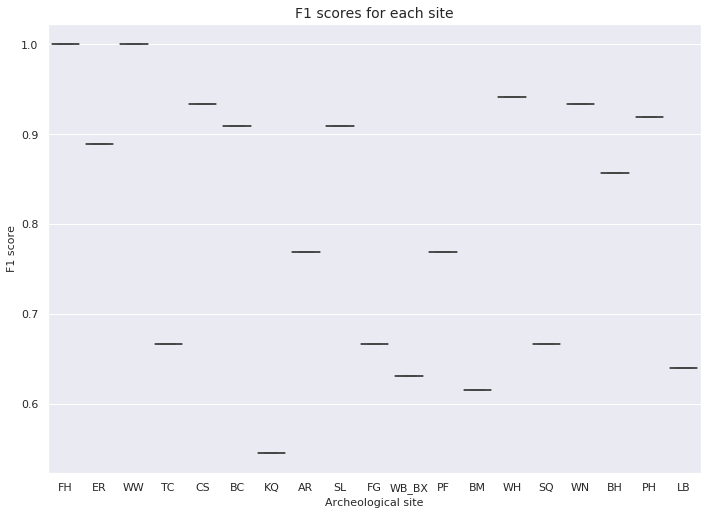

In [17]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
plot = sns.boxplot(data = f1_df_final.T)
plot.set_title('F1 scores for each site', fontdict={'fontsize': 14})
plot.set_ylabel('F1 score', fontdict={'fontsize': 11})
plot.set_xlabel("Archeological site", fontdict={'fontsize': 11})

if save_plots:
    fig = plot.get_figure()
    fig.savefig('site_specific_f1_scores.png')

In [18]:
if save_plots:
    pd.DataFrame(data = f1_df_final.T.median()).to_csv('median_class_f1_scores.csv')

### Boxplot showing the macro F1 score

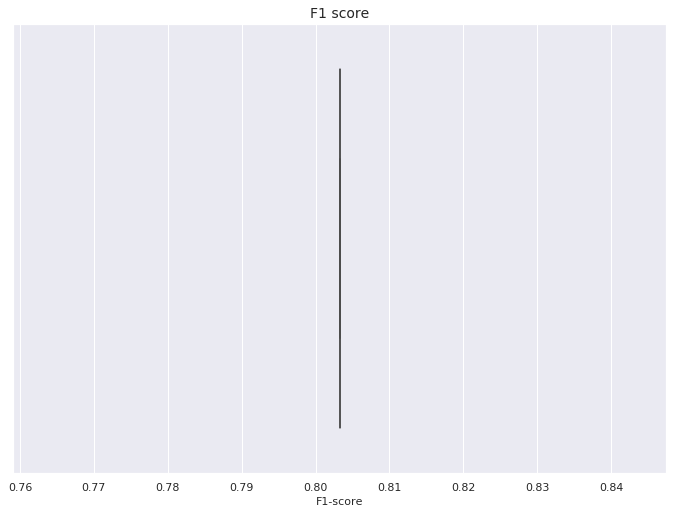

In [19]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
plot = sns.boxplot(macro_f1_scores)
plot.set_title('F1 score', fontdict={'fontsize': 14})
plot.set_xlabel("F1-score", fontdict={'fontsize': 11})

if save_plots == True:
    fig = plot.get_figure()
    fig.savefig('average-weighted f1_scores.png')

In [20]:
if save_plots:
    pd.Series(pd.Series(macro_f1_scores).median()).to_csv('median_macro_f1.csv')

In [21]:
pd.Series(macro_f1_scores).median()

0.803255540371395

### Boxplot showing accuracy scores

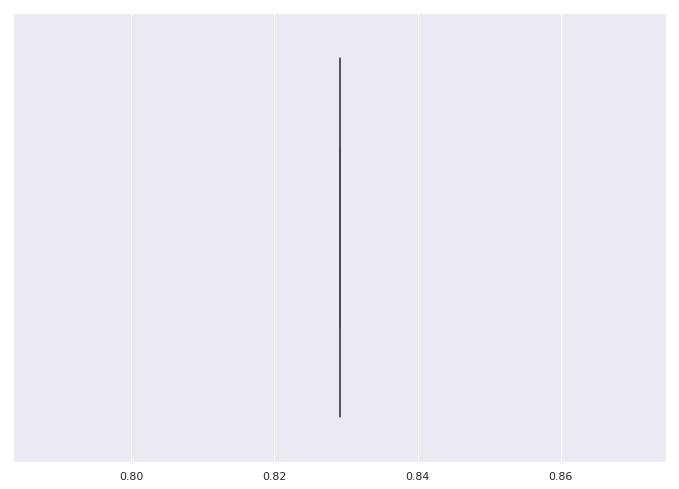

In [22]:
sns.boxplot(accuracy_scores)

### Get feature importances

In [23]:
feat_imp_df = pd.DataFrame(data = feat_imp_dict)
feat_imp_df.head()

""


In [24]:
feat_imp_df_final = pd.concat([feat_imp_df, pd.Series(my_data[best_feats].columns.values)], axis = 1)
feat_imp_df_final.rename(columns = {0:'element'}, inplace = True )
feat_imp_df_final.head()

,element
0,Li7
1,Nd146
2,Pr141
3,Ba137
4,Sr88


In [25]:
feat_imp_df_final.set_index('element', inplace=True)


In [26]:
feat_imp_df_final_plot = feat_imp_df_final.T

In [27]:
feat_imp_df_final_plot

elements = feat_imp_df_final_plot.columns.values 
mean_feature_importance = []
for col in list(feat_imp_df_final_plot.columns.values):
    mean_feature_importance.append(feat_imp_df_final_plot[col].mean())
    

In [28]:
mean_feature_importance_df = pd.concat([pd.Series(elements), pd.Series(mean_feature_importance)], axis = 1)

In [29]:
mean_feature_importance_df.rename(columns={0:'elements', 1:'mean_importance'}, inplace=True)

In [30]:
mean_feature_importance_df.sort_values(by='mean_importance', ascending=False, inplace=True)

In [31]:
ordered_col_names = list(mean_feature_importance_df['elements'])

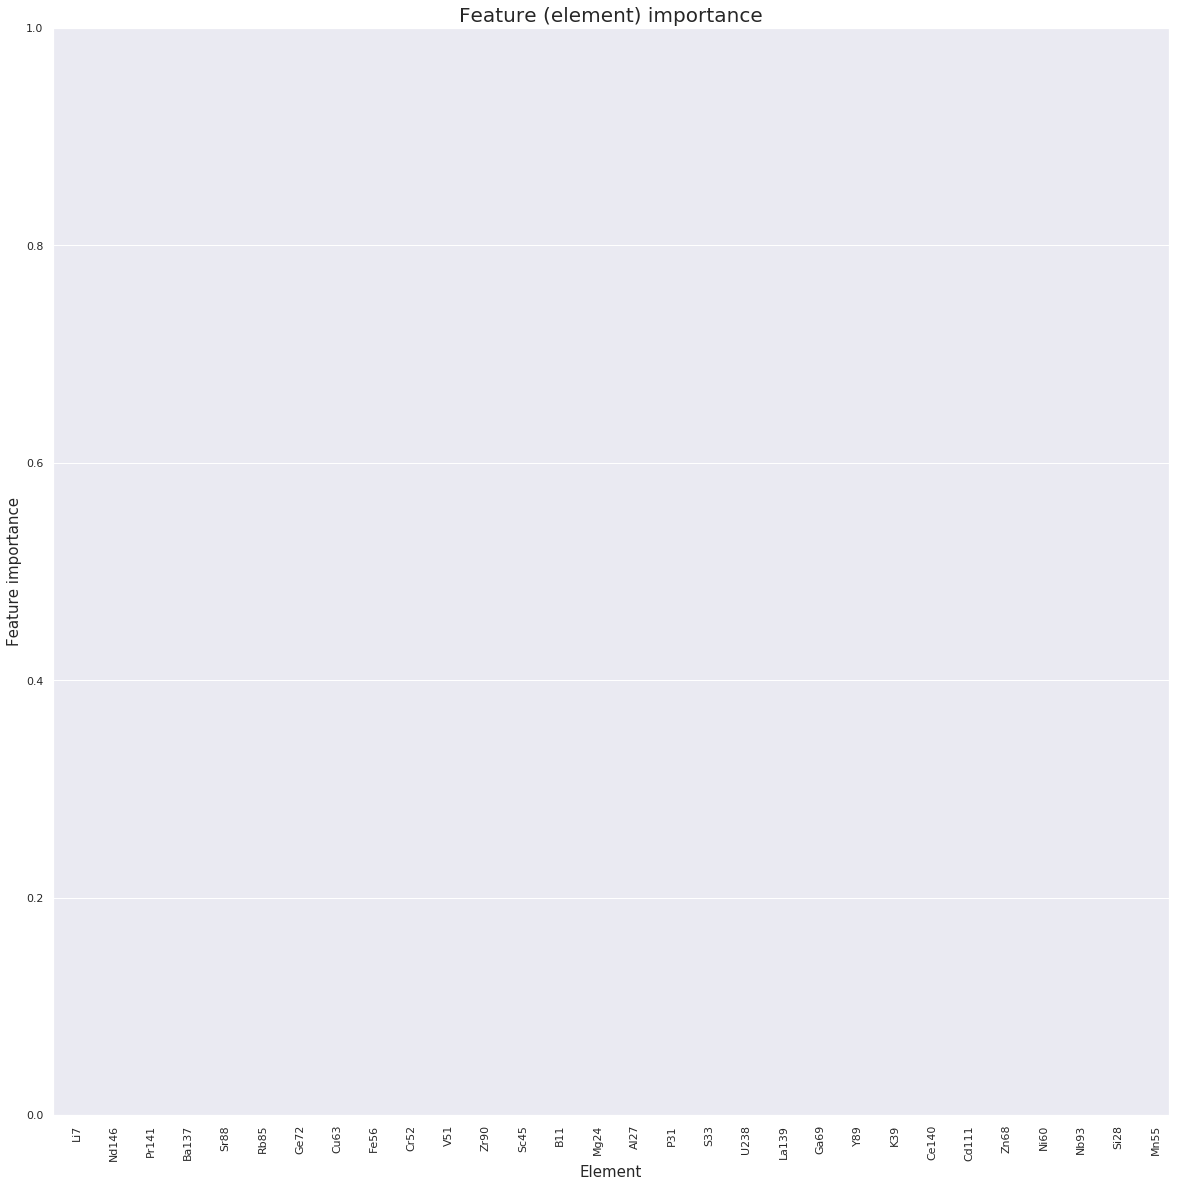

In [32]:
sns.set_style("whitegrid")
sns.set_style()
sns.set(rc={'figure.figsize':(20,20)})
plot = sns.boxplot(data = feat_imp_df_final_plot[ordered_col_names])
plot.set_xticklabels(plot.get_xticklabels(),rotation=90, ha = 'left')
plot.set_title('Feature (element) importance', fontdict={'fontsize': 20})
plot.set_ylabel('Feature importance', fontdict={'fontsize': 15})
plot.set_xlabel("Element", fontdict={'fontsize': 15})

if save_plots:
    fig = plot.get_figure()
    fig.savefig('feature_importances.png')

### show relationship between sample size and class F1 scores

In [150]:
site_frequencies_df.head()

,class,number of observations
0,CS,105
1,PH,100
2,Pimple,78
3,LB,61
4,CR,60


In [170]:
site_frequencies_df.rename(columns = {'Site':'class'}, inplace=True)

In [171]:
f1_scores_for_plot = f1_df_final.reset_index(drop = False)

In [172]:
f1_scores_for_plot['Mean F1 Score'] = f1_scores_for_plot.mean(axis = 1)

In [173]:
combined_df = site_frequencies_df.set_index('class').join(other = f1_scores_for_plot.set_index('class'), how = 'inner')

In [174]:
forPlot = combined_df.reset_index(drop = False).rename(columns = {'index':'class'})[['class', 'Number of Observations', 'Mean F1 Score']]

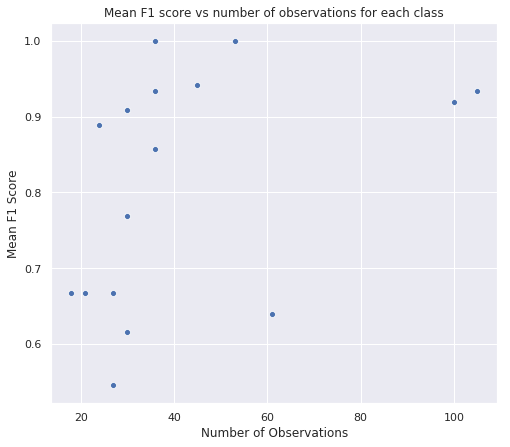

In [190]:
sns.set(rc={'figure.figsize':(8,7)})
plot = sns.scatterplot(x ='Number of Observations', y = 'Mean F1 Score', data = forPlot, ci=False)
ax = plt.gca()
ax.set_title("Mean F1 score vs number of observations for each class")
fig = plot.get_figure()
fig.savefig('figures/f1scoresvsnumberobservations.png')




In [159]:
forPlot

,class,number of observations,mean F1 score
0,CS,105,0.933333
1,PH,100,0.918919
2,LB,61,0.640000
3,FH,53,1.000000
4,WH,45,0.941176
5,BH,36,0.857143
6,WN,36,0.933333
7,WW,36,1.000000
8,PF,30,0.769231
9,AR,30,0.769231


In [69]:
f1_scores_for_plot.head()

,class,round1,round2,round3,round4,round5,round6,round7,round8,round9,round10
0,FH,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,ER,0.888889,0.888889,0.888889,0.888889,0.888889,0.888889,0.888889,0.888889,0.888889,0.888889
2,WW,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,TC,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667
4,CS,0.933333,0.933333,0.933333,0.933333,0.933333,0.933333,0.933333,0.933333,0.933333,0.933333


### Model is built for predicting source of artefacts 

In [33]:
esti_final = RandomForestClassifier(n_estimators=2000, random_state = random_seed_state)

In [34]:
esti_final.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [35]:
print(train_data_formodel['class'].unique())
print(uniques)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
Index(['FH', 'ER', 'WW', 'TC', 'CS', 'BC', 'KQ', 'AR', 'SL', 'FG', 'WB_BX',
       'PF', 'BM', 'WH', 'SQ', 'WN', 'BH', 'PH', 'LB'],
      dtype='object')


In [36]:
identifiers =  X_test_labeled_df['Analysis']

### Predictions are made for the artefacts

In [37]:
X_test_labeled_df.columns.values[1:-1]

array(['Li7', 'Nd146', 'Pr141', 'Ba137', 'Sr88', 'Rb85', 'Ge72', 'Cu63',
       'Fe56', 'Cr52', 'V51', 'Zr90', 'Sc45', 'B11', 'Mg24', 'Al27',
       'P31', 'S33', 'U238', 'La139', 'Ga69', 'Y89', 'K39', 'Ce140',
       'Cd111', 'Zn68', 'Ni60', 'Nb93', 'Si28', 'Mn55'], dtype=object)

In [38]:
y_pred = esti_final.predict(np.array(X_test_labeled_df[X_test_labeled_df.columns.values[1:-1]]))

y_pred_proba = esti_final.predict_proba(np.array(X_test_labeled_df[X_test_labeled_df.columns.values[1:-1]]))


In [39]:
probabilities_df = pd.DataFrame(data = y_pred_proba, columns = uniques)
probabilities_df_final = pd.concat([probabilities_df, identifiers], axis = 1)

In [40]:
probabilities_df_final.head()

,FH,ER,WW,TC,CS,BC,KQ,AR,SL,FG,WB_BX,PF,BM,WH,SQ,WN,BH,PH,LB,Analysis
0,0.1520,0.0255,0.0040,0.0050,0.057,0.0155,0.0250,0.1035,0.0060,0.0405,0.0665,0.2110,0.0125,0.0100,0.0045,0.0490,0.0425,0.0825,0.0875,06_DH1_1
1,0.1510,0.0240,0.0045,0.0045,0.056,0.0165,0.0240,0.1025,0.0065,0.0420,0.0640,0.2260,0.0135,0.0100,0.0055,0.0470,0.0435,0.0785,0.0805,07_DH1_2
2,0.1475,0.0230,0.0040,0.0045,0.058,0.0165,0.0265,0.0985,0.0060,0.0410,0.0615,0.2250,0.0135,0.0100,0.0045,0.0495,0.0455,0.0780,0.0870,08_DH1_3
3,0.1415,0.0240,0.0040,0.0050,0.053,0.0150,0.0285,0.1095,0.0090,0.0455,0.0750,0.2230,0.0135,0.0095,0.0055,0.0425,0.0415,0.0855,0.0690,09_DH2_1
4,0.1400,0.0240,0.0050,0.0055,0.050,0.0175,0.0265,0.1080,0.0055,0.0430,0.0685,0.2295,0.0155,0.0115,0.0050,0.0425,0.0465,0.0835,0.0725,10_DH2_2


In [41]:
final_pred_df = pd.concat([pd.Series(y_pred), probabilities_df_final], axis = 1).rename(columns={0:'class_number'})

In [42]:
final_pred_df.head()

,class_number,FH,ER,WW,TC,CS,BC,KQ,AR,SL,FG,WB_BX,PF,BM,WH,SQ,WN,BH,PH,LB,Analysis
0,11,0.1520,0.0255,0.0040,0.0050,0.057,0.0155,0.0250,0.1035,0.0060,0.0405,0.0665,0.2110,0.0125,0.0100,0.0045,0.0490,0.0425,0.0825,0.0875,06_DH1_1
1,11,0.1510,0.0240,0.0045,0.0045,0.056,0.0165,0.0240,0.1025,0.0065,0.0420,0.0640,0.2260,0.0135,0.0100,0.0055,0.0470,0.0435,0.0785,0.0805,07_DH1_2
2,11,0.1475,0.0230,0.0040,0.0045,0.058,0.0165,0.0265,0.0985,0.0060,0.0410,0.0615,0.2250,0.0135,0.0100,0.0045,0.0495,0.0455,0.0780,0.0870,08_DH1_3
3,11,0.1415,0.0240,0.0040,0.0050,0.053,0.0150,0.0285,0.1095,0.0090,0.0455,0.0750,0.2230,0.0135,0.0095,0.0055,0.0425,0.0415,0.0855,0.0690,09_DH2_1
4,11,0.1400,0.0240,0.0050,0.0055,0.050,0.0175,0.0265,0.1080,0.0055,0.0430,0.0685,0.2295,0.0155,0.0115,0.0050,0.0425,0.0465,0.0835,0.0725,10_DH2_2


### labels outputted by local outlier factor model are appended to predictions

In [43]:
final_predictions_df = pd.concat([final_pred_df, X_test_labeled_df['inlierLabel']], axis = 1)

In [44]:
final_predictions_df.head()

,class_number,FH,ER,WW,TC,CS,BC,KQ,AR,SL,FG,WB_BX,PF,BM,WH,SQ,WN,BH,PH,LB,Analysis,inlierLabel
0,11,0.1520,0.0255,0.0040,0.0050,0.057,0.0155,0.0250,0.1035,0.0060,0.0405,0.0665,0.2110,0.0125,0.0100,0.0045,0.0490,0.0425,0.0825,0.0875,06_DH1_1,1
1,11,0.1510,0.0240,0.0045,0.0045,0.056,0.0165,0.0240,0.1025,0.0065,0.0420,0.0640,0.2260,0.0135,0.0100,0.0055,0.0470,0.0435,0.0785,0.0805,07_DH1_2,1
2,11,0.1475,0.0230,0.0040,0.0045,0.058,0.0165,0.0265,0.0985,0.0060,0.0410,0.0615,0.2250,0.0135,0.0100,0.0045,0.0495,0.0455,0.0780,0.0870,08_DH1_3,1
3,11,0.1415,0.0240,0.0040,0.0050,0.053,0.0150,0.0285,0.1095,0.0090,0.0455,0.0750,0.2230,0.0135,0.0095,0.0055,0.0425,0.0415,0.0855,0.0690,09_DH2_1,1
4,11,0.1400,0.0240,0.0050,0.0055,0.050,0.0175,0.0265,0.1080,0.0055,0.0430,0.0685,0.2295,0.0155,0.0115,0.0050,0.0425,0.0465,0.0835,0.0725,10_DH2_2,1


In [45]:
uniques_list = list(uniques)
def get_pred_names(row):
    return(uniques_list[row['class_number']])
final_predictions_df['class_predictions'] = final_predictions_df.apply(get_pred_names, axis = 1)

In [46]:
final_predictions_df.head()

,class_number,FH,ER,WW,TC,CS,BC,KQ,AR,SL,FG,WB_BX,PF,BM,WH,SQ,WN,BH,PH,LB,Analysis,inlierLabel,class_predictions
0,11,0.1520,0.0255,0.0040,0.0050,0.057,0.0155,0.0250,0.1035,0.0060,0.0405,0.0665,0.2110,0.0125,0.0100,0.0045,0.0490,0.0425,0.0825,0.0875,06_DH1_1,1,PF
1,11,0.1510,0.0240,0.0045,0.0045,0.056,0.0165,0.0240,0.1025,0.0065,0.0420,0.0640,0.2260,0.0135,0.0100,0.0055,0.0470,0.0435,0.0785,0.0805,07_DH1_2,1,PF
2,11,0.1475,0.0230,0.0040,0.0045,0.058,0.0165,0.0265,0.0985,0.0060,0.0410,0.0615,0.2250,0.0135,0.0100,0.0045,0.0495,0.0455,0.0780,0.0870,08_DH1_3,1,PF
3,11,0.1415,0.0240,0.0040,0.0050,0.053,0.0150,0.0285,0.1095,0.0090,0.0455,0.0750,0.2230,0.0135,0.0095,0.0055,0.0425,0.0415,0.0855,0.0690,09_DH2_1,1,PF
4,11,0.1400,0.0240,0.0050,0.0055,0.050,0.0175,0.0265,0.1080,0.0055,0.0430,0.0685,0.2295,0.0155,0.0115,0.0050,0.0425,0.0465,0.0835,0.0725,10_DH2_2,1,PF


### final predictions including assignments from local outlier factor model are added

In [47]:
def outlierAssigner(row):
    if row['inlierLabel'] == -1:
        return('other')
    else:
        return(row['class_predictions'])
    
final_predictions_df['class_predictions'] = final_predictions_df.swifter.apply(outlierAssigner, axis = 1)

In [48]:
final_predictions_df.head()

,class_number,FH,ER,WW,TC,CS,BC,KQ,AR,SL,FG,WB_BX,PF,BM,WH,SQ,WN,BH,PH,LB,Analysis,inlierLabel,class_predictions
0,11,0.1520,0.0255,0.0040,0.0050,0.057,0.0155,0.0250,0.1035,0.0060,0.0405,0.0665,0.2110,0.0125,0.0100,0.0045,0.0490,0.0425,0.0825,0.0875,06_DH1_1,1,PF
1,11,0.1510,0.0240,0.0045,0.0045,0.056,0.0165,0.0240,0.1025,0.0065,0.0420,0.0640,0.2260,0.0135,0.0100,0.0055,0.0470,0.0435,0.0785,0.0805,07_DH1_2,1,PF
2,11,0.1475,0.0230,0.0040,0.0045,0.058,0.0165,0.0265,0.0985,0.0060,0.0410,0.0615,0.2250,0.0135,0.0100,0.0045,0.0495,0.0455,0.0780,0.0870,08_DH1_3,1,PF
3,11,0.1415,0.0240,0.0040,0.0050,0.053,0.0150,0.0285,0.1095,0.0090,0.0455,0.0750,0.2230,0.0135,0.0095,0.0055,0.0425,0.0415,0.0855,0.0690,09_DH2_1,1,PF
4,11,0.1400,0.0240,0.0050,0.0055,0.050,0.0175,0.0265,0.1080,0.0055,0.0430,0.0685,0.2295,0.0155,0.0115,0.0050,0.0425,0.0465,0.0835,0.0725,10_DH2_2,1,PF


### predictions are stored as a variable into memory

In [49]:
%store final_predictions_df

Stored 'final_predictions_df' (DataFrame)


### predictions are outputted as csv file

In [50]:
if save_predictions:
    final_predictions_df.to_csv('predictions.csv')
